# Introduction
Body fat percentage is total mass of fat divided by total body mass, it is a important factor to show a person's health level, too high or too low will caused diseases. There are some body fat calculators online, however, there are too many variables. In this project, we try to find a simple, accurate and robust model to predict boday fat Percentage which obeys the 'Rule of Thumb'.

# Part 1: Dealing with raw data

In [1]:
install.packages("car")
install.packages("leaps")
install.packages("faraway")
install.packages("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Warning message in install.packages("car"):
“'lib = "/usr/local/lib/R/site-library"' is not writable”

ERROR: Error in install.packages("car"): unable to install packages


In [1]:
library(car)
library(leaps)
library(faraway)
library(glmnet)

Loading required package: carData


Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



Attaching package: ‘faraway’



The following objects are masked from ‘package:car’:

    logit, vif



Loading required package: Matrix


Loading required package: foreach


Loaded glmnet 2.0-18



#### Read in the raw data and do data cleaning (detect points which bodyfat does not have a linear relationship of 1 / density), then get rid of the variable: "density":

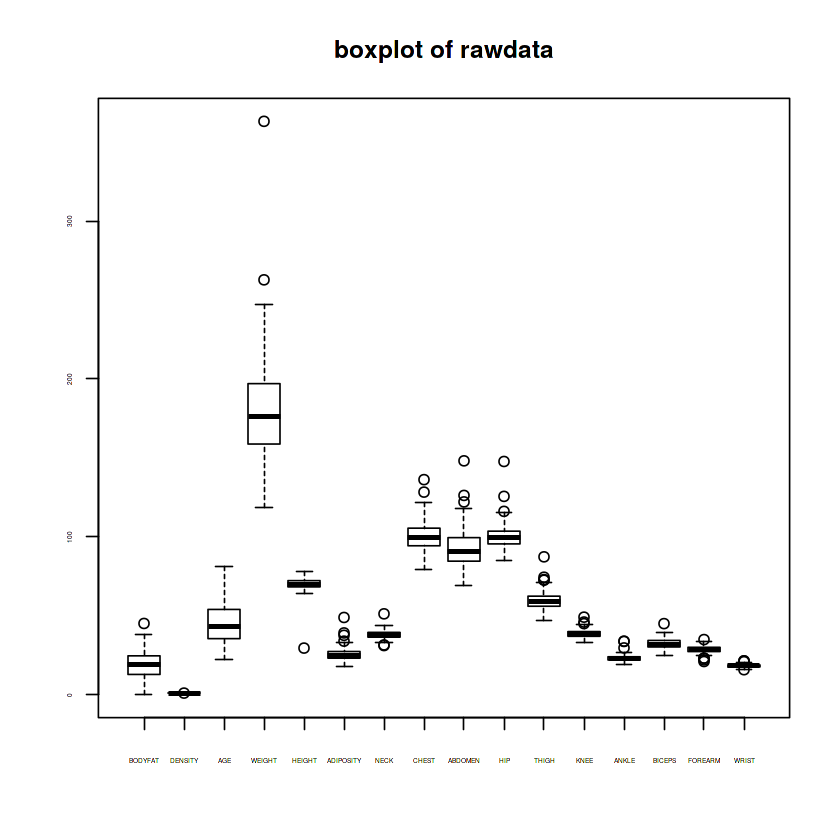

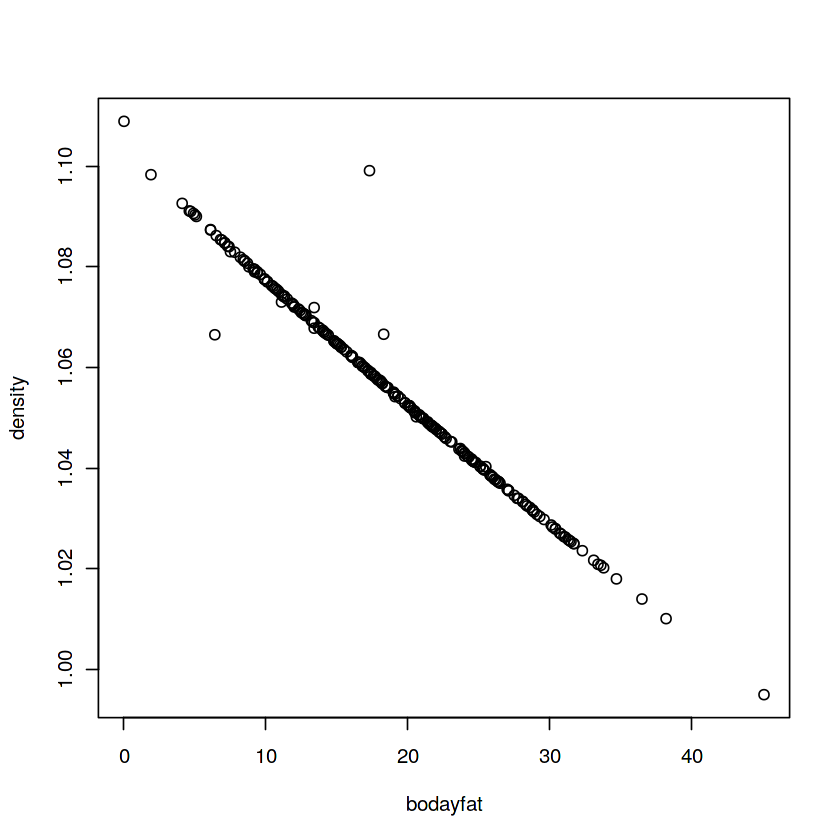

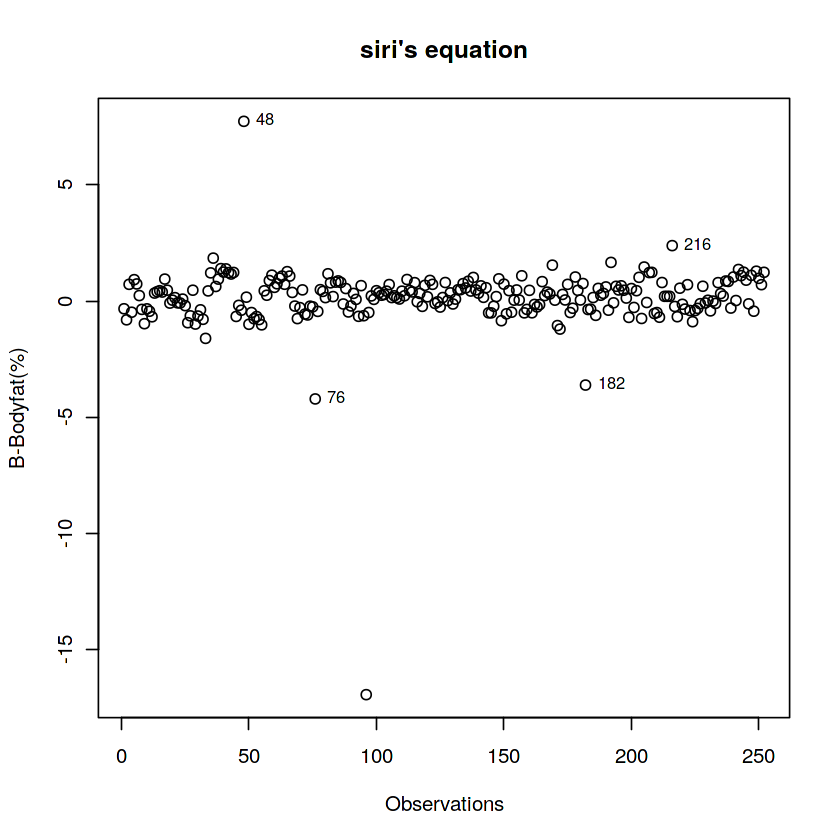

In [8]:
data = read.csv("BodyFat.csv",row.names=1)
boxplot(data,main="boxplot of rawdata",cex.axis=0.3)  
# data cleaning 
plot(data$BODYFAT,data$DENSITY,xlab="bodayfat",ylab="density")
# detect points which bodyfat does not have a linear relationship of 1 / density
B = 495*(1/data$DENSITY)-450
plot(B-data$BODYFAT,xlab = 'Observations', ylab = 'B-Bodyfat(%)', main = "siri's equation")
text(c(48,76,182,216), B[c(48,76,182,216)]-data$BODYFAT[c(48,76,182,216)], c(48,76,182,216),cex=0.8,pos=4)
data_new = data[, -2]

#### Check the cook's distance one by one:

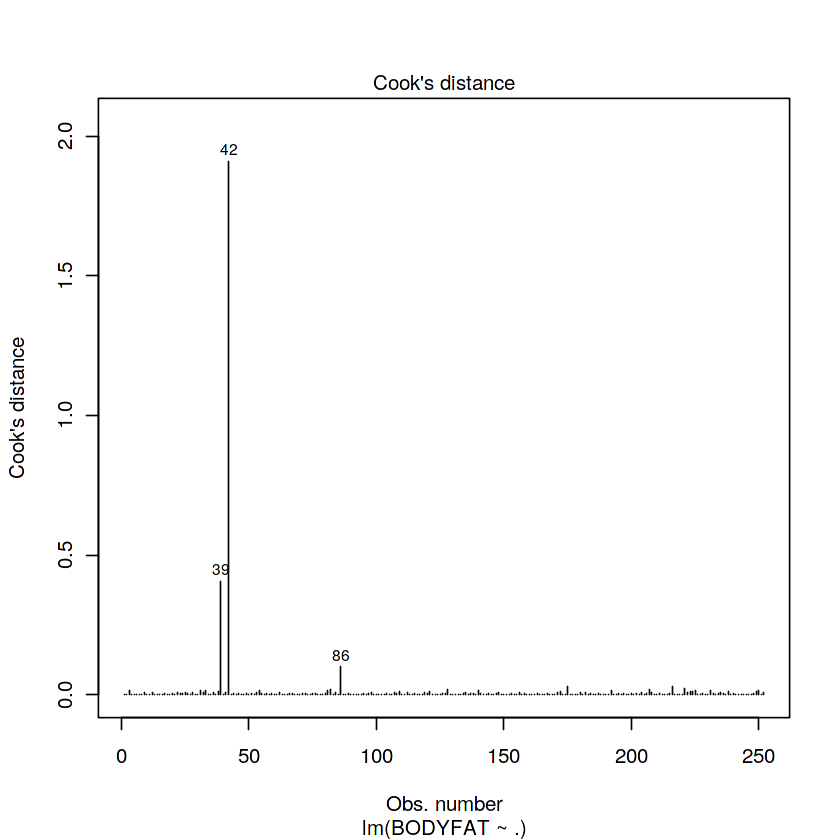

In [3]:
model1<- lm(BODYFAT ~ ., data = data_new)
plot(model1, which = 4)

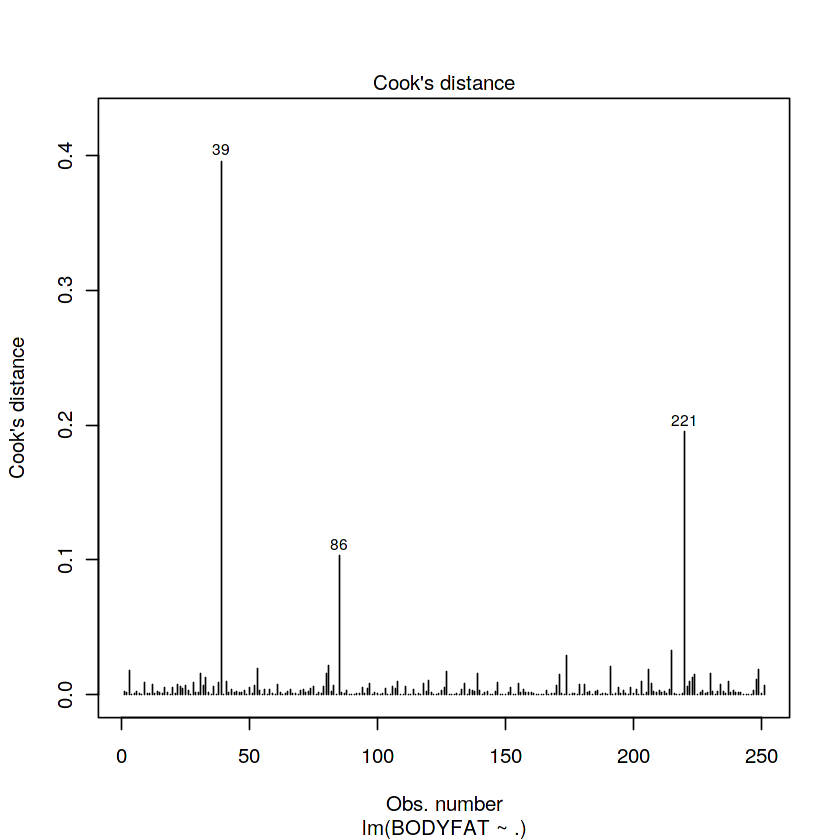

In [4]:
model2<- lm(BODYFAT ~ ., data = data_new[-42,])
plot(model2, which = 4)

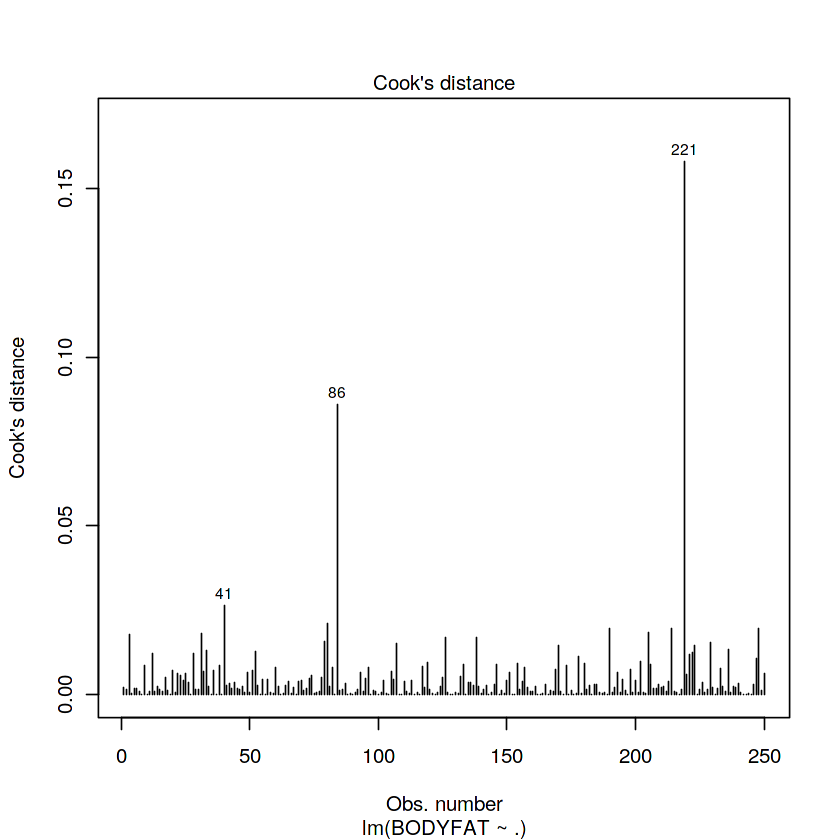

In [5]:
model3<- lm(BODYFAT ~ ., data = data_new[-c(39,42),])
plot(model3, which = 4)

#### Then delete possible outliers. No.39 has too large weight; No.42 is way too short; 
#### No.8,No.76,No.96 does not match the relationship between bodyfat and density;
#### No.182 has bodyfat 0, it is a mistake.
#### We remove them and scale the data.

In [9]:
data[c(39, 42, 48, 96, 76, 182),]
data_clean = data_new[c(-39, -42, -48, -96, -76, -182), ]
data_clean<-data.frame(scale(data_clean))
#we try to normalize the data, the variable selection results are the same,so at the end when we build the final odel we still use the not scaled data.
write.csv(data_clean,"bodyfat_clean.csv",row.names = F)

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
39,33.8,1.0202,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
42,31.7,1.0250,44,205.00,29.50,29.9,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4
48,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9
96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4
76,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0,18.3
182,0.0,1.1089,40,118.50,68.00,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5


#### We check new data's Cook's distance again and find nothing weird. The possible outlier No.221 might be caused by randomness. 

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
221,12.7,1.0706,54,153.25,70.5,24.5,38.5,99,91.8,96.2,57.7,38.1,23.9,31.4,29.9,18.9


No Studentized residuals with Bonferroni p < 0.05
Largest |rstudent|:
     rstudent unadjusted p-value Bonferroni p
224 -2.592132           0.010149           NA

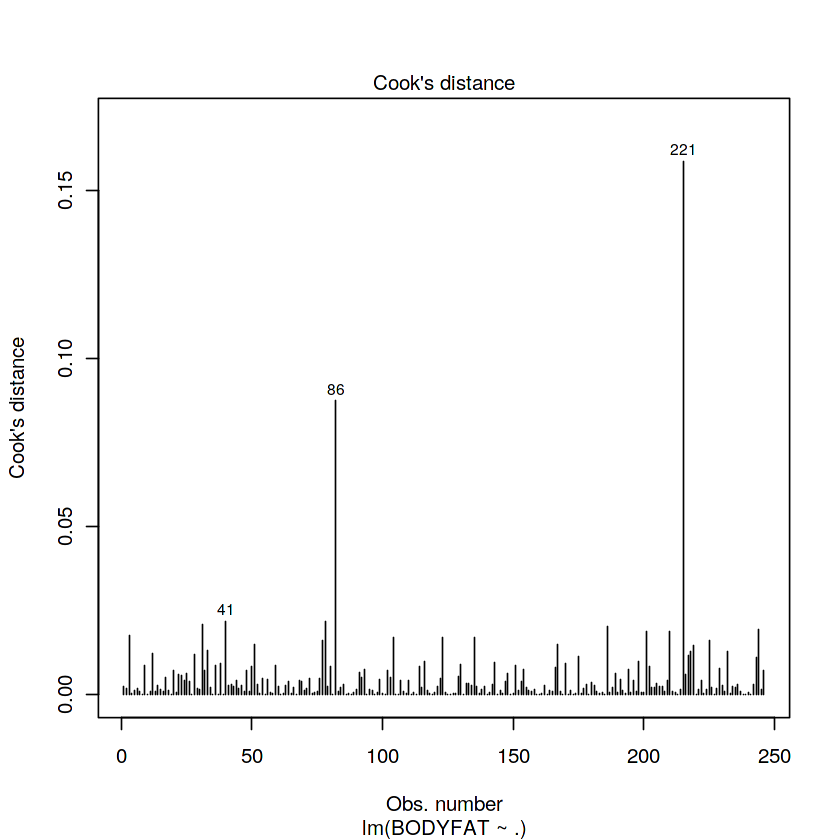

In [10]:
model = lm(BODYFAT ~ ., data = data_clean)
plot(model, which = 4)
data[221,]

# outlier test
outlierTest(model)

# Part 2: Model selection

#### The methods we use are: AIC, BIC, Mallow's Cp, Adjusted-R^2 and lasso.

In [11]:
full = lm(BODYFAT ~ ., data = data_clean)
base = lm(BODYFAT ~ 1, data = data_clean)

#### 1. AIC (Backward, forward and both sides)

In [12]:
model_AIC_b = step(full, direction = "backward", trace = 0)
print(model_AIC_b)

model_AIC_f = step(base, direction = "forward", trace = 0,scope = list(lower = base, upper = full))
print(model_AIC_f)

model_AIC_t = step(base, direction = "both", trace = 0, scope = list(lower = base, upper = full))
print(model_AIC_t)


Call:
lm(formula = BODYFAT ~ AGE + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + BICEPS + WRIST, data = data_clean)

Coefficients:
(Intercept)          AGE    ADIPOSITY         NECK        CHEST      ABDOMEN  
  7.016e-16    8.637e-02    2.449e-01   -1.095e-01   -2.244e-01    1.075e+00  
        HIP       BICEPS        WRIST  
 -1.780e-01    8.687e-02   -1.992e-01  




Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST       BICEPS  
  7.303e-16    1.187e+00   -3.817e-01   -1.659e-01    1.028e-01  




Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST       BICEPS  
  7.303e-16    1.187e+00   -3.817e-01   -1.659e-01    1.028e-01  



#### 2. BIC (Backward, forward and both sides)

In [13]:
n = dim(data)[1]
model_BIC_b = step(full, direction = "backward", trace = 0, k = log(n))
print(model_BIC_b)
summary(model_BIC_b)

model_BIC_f = step(base, direction = "forward", trace = 0, scope = list(lower = base, upper = full), k = log(n))
print(model_BIC_f )

model_BIC_t = step(full, direction = "both", trace = 0, k = log(n))
print(model_BIC_t)
summary(model_BIC_t)


Call:
lm(formula = BODYFAT ~ AGE + ABDOMEN + WRIST, data = data_clean)

Coefficients:
(Intercept)          AGE      ABDOMEN        WRIST  
  6.057e-16    1.154e-01    9.482e-01   -2.587e-01  




Call:
lm(formula = BODYFAT ~ AGE + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.22877 -0.36001 -0.06389  0.39959  1.28253 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.057e-16  3.354e-02   0.000  1.00000    
AGE          1.154e-01  3.479e-02   3.316  0.00105 ** 
ABDOMEN      9.482e-01  4.244e-02  22.342  < 2e-16 ***
WRIST       -2.587e-01  4.210e-02  -6.146 3.25e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.526 on 242 degrees of freedom
Multiple R-squared:  0.7267,	Adjusted R-squared:  0.7233 
F-statistic: 214.5 on 3 and 242 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST  
  7.316e-16    1.173e+00   -2.967e-01   -1.556e-01  




Call:
lm(formula = BODYFAT ~ ABDOMEN + WRIST + HEIGHT, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN        WRIST       HEIGHT  
  2.454e-16    9.591e-01   -1.918e-01   -1.293e-01  




Call:
lm(formula = BODYFAT ~ ABDOMEN + WRIST + HEIGHT, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.19183 -0.38444 -0.03496  0.37947  1.19786 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.454e-16  3.342e-02   0.000  1.00000    
ABDOMEN      9.591e-01  4.191e-02  22.884  < 2e-16 ***
WRIST       -1.918e-01  4.459e-02  -4.301 2.47e-05 ***
HEIGHT      -1.293e-01  3.628e-02  -3.564  0.00044 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5242 on 242 degrees of freedom
Multiple R-squared:  0.7285,	Adjusted R-squared:  0.7252 
F-statistic: 216.5 on 3 and 242 DF,  p-value: < 2.2e-16


#### 3. Mallow's cp

[1] "AGE"     "HEIGHT"  "CHEST"   "ABDOMEN" "BICEPS"  "WRIST"  



Call:
lm(formula = cp_model, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.26853 -0.37613 -0.02628  0.39564  1.09015 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.003e-16  3.294e-02   0.000  1.00000    
AGE          8.909e-02  3.851e-02   2.313  0.02156 *  
HEIGHT      -1.043e-01  3.850e-02  -2.709  0.00725 ** 
CHEST       -1.741e-01  8.572e-02  -2.031  0.04340 *  
ABDOMEN      1.053e+00  8.070e-02  13.045  < 2e-16 ***
BICEPS       8.001e-02  5.142e-02   1.556  0.12102    
WRIST       -2.148e-01  4.925e-02  -4.362 1.92e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5167 on 239 degrees of freedom
Multiple R-squared:  0.7396,	Adjusted R-squared:  0.733 
F-statistic: 113.1 on 6 and 239 DF,  p-value: < 2.2e-16


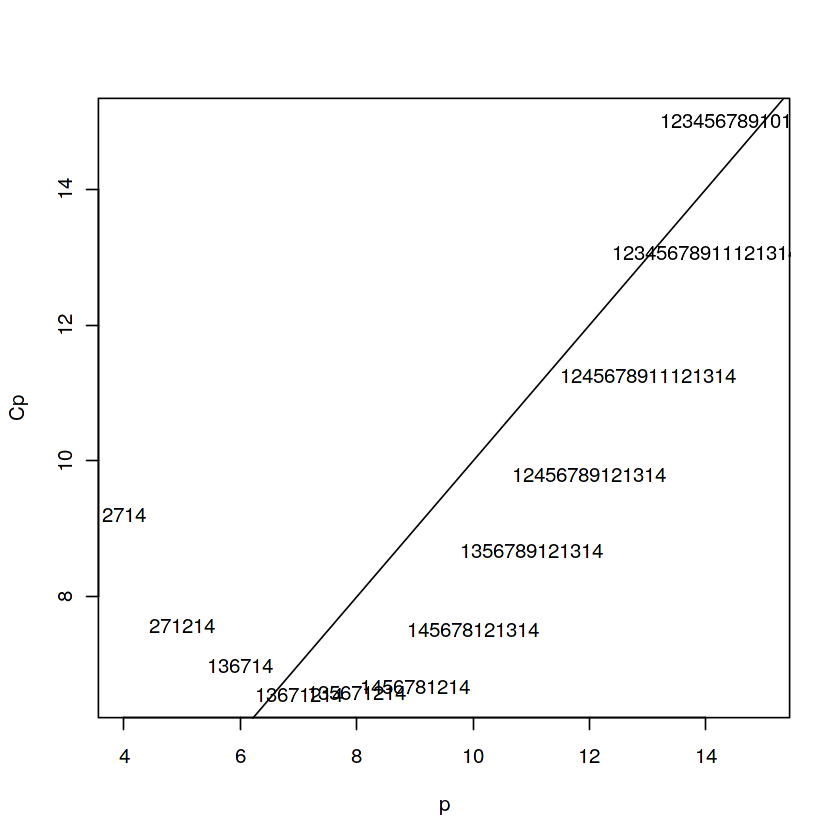

In [14]:
X = data_clean[, -1]
Y = data_clean$BODYFAT
g = leaps(X, Y, nbest = 1)
Cpplot(g)
print(colnames(data_clean)[c(1, 3, 6, 7, 12, 14) + 1])
cp_model = BODYFAT ~ AGE + HEIGHT + CHEST + ABDOMEN +  BICEPS + WRIST
cp_lm = lm(cp_model, data=data_clean)
summary(cp_lm)

#### 4. Adjusted R square

In [15]:
g_ad = leaps(X, Y, nbest = 1,method="adjr2")
plot(g_ad$adjr2
(g_ad$which)[which(g_ad$adjr2==max(g_ad$adjr2)),]
Ad_r=BODYFAT~AGE+ADIPOSITY+NECK+CHEST+ABDOMEN+HIP+BICEPS+FOREARM+WRIST
adr_model<-lm(Ad_r,data=data_clean)
print(adr_model)

ERROR: Error in parse(text = x, srcfile = src): <text>:4:1: unexpected symbol
3: (g_ad$which)[which(g_ad$adjr2==max(g_ad$adjr2)),]
4: Ad_r
   ^


#### 5. Lasso


Call:  glmnet(x = as.matrix(data_clean[, 2:15]), y = data_clean$BODYFAT,      family = "gaussian", alpha = 1, nlambda = 50, standardize = T) 

      Df   %Dev    Lambda
 [1,]  0 0.0000 0.8200000
 [2,]  1 0.2116 0.6795000
 [3,]  1 0.3568 0.5631000
 [4,]  1 0.4566 0.4666000
 [5,]  1 0.5251 0.3866000
 [6,]  1 0.5721 0.3204000
 [7,]  1 0.6044 0.2655000
 [8,]  1 0.6266 0.2200000
 [9,]  1 0.6418 0.1823000
[10,]  2 0.6523 0.1511000
[11,]  2 0.6697 0.1252000
[12,]  2 0.6816 0.1037000
[13,]  3 0.6901 0.0859500
[14,]  4 0.7037 0.0712200
[15,]  4 0.7131 0.0590100
[16,]  4 0.7196 0.0489000
[17,]  4 0.7241 0.0405200
[18,]  4 0.7271 0.0335800
[19,]  5 0.7296 0.0278200
[20,]  5 0.7316 0.0230600
[21,]  7 0.7339 0.0191100
[22,]  7 0.7358 0.0158300
[23,]  9 0.7371 0.0131200
[24,] 10 0.7392 0.0108700
[25,] 11 0.7411 0.0090080
[26,] 11 0.7429 0.0074640
[27,] 11 0.7441 0.0061850
[28,] 11 0.7449 0.0051250
[29,] 11 0.7454 0.0042470
[30,] 12 0.7458 0.0035190
[31,] 13 0.7462 0.0029160
[32,] 13 0.7464 0.002417

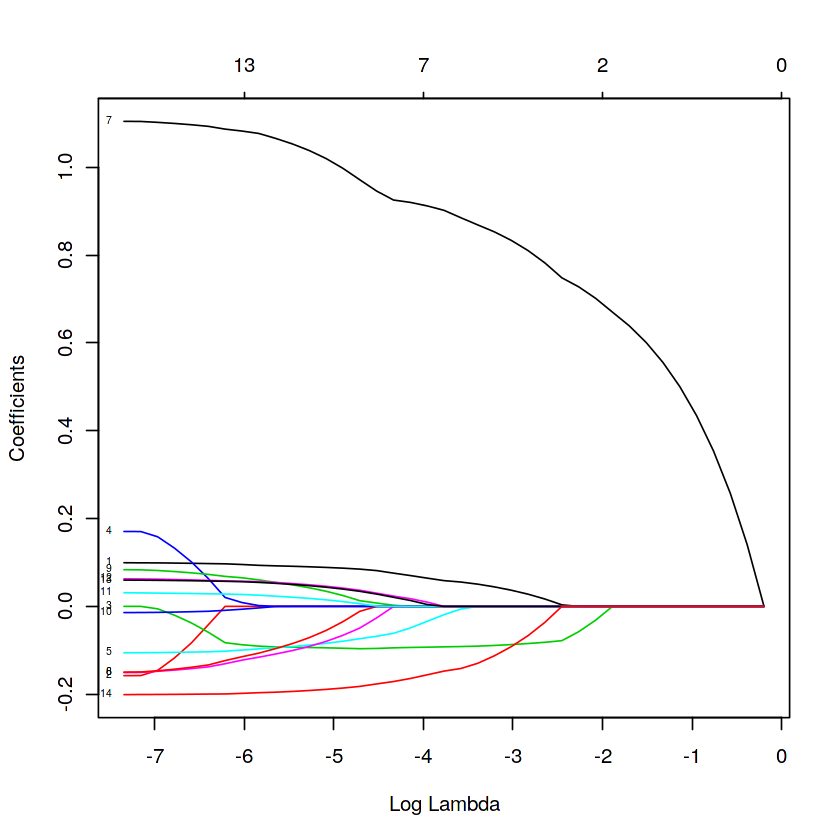

15 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  2.634665e-16
AGE          3.551479e-02
WEIGHT       .           
HEIGHT      -8.664372e-02
ADIPOSITY    .           
NECK         .           
CHEST        .           
ABDOMEN      8.302921e-01
HIP          .           
THIGH        .           
KNEE         .           
ANKLE        .           
BICEPS       .           
FOREARM      .           
WRIST       -8.796635e-02



Call:
lm(formula = BODYFAT ~ AGE + HEIGHT + ABDOMEN + WRIST, data = data_clean)

Coefficients:
(Intercept)          AGE       HEIGHT      ABDOMEN        WRIST  
  3.245e-16    8.103e-02   -9.832e-02    9.466e-01   -2.132e-01  



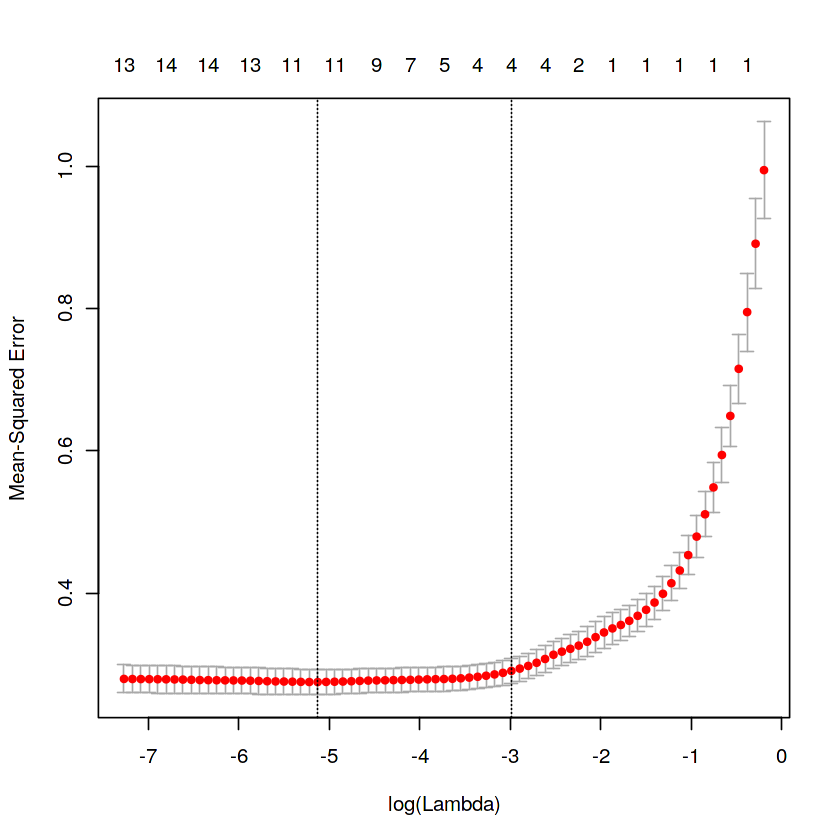

In [16]:
model_l <- glmnet(as.matrix(data_clean[,2:15]), data_clean$BODYFAT, family = "gaussian", nlambda = 50, alpha = 1,standardize = T)
print(model_l)
plot(model_l, xvar = "lambda", label = T)
cvfit <- cv.glmnet(as.matrix(data_clean[,2:15]), data_clean$BODYFAT, family = "gaussian", type.measure = "mse", nfolds = 10,alpha = 1)
plot(cvfit)
print(coef(cvfit, s = "lambda.1se" ))
model_lasso<- BODYFAT ~ AGE + HEIGHT  + ABDOMEN +  WRIST
model_l<-lm(BODYFAT ~ AGE + HEIGHT  + ABDOMEN +  WRIST,data=data_clean)
print(model_l)

# Part3: Other analysis

#### We compare the models above by their summary table and plots. 

In [16]:
summary(model_AIC_b)
summary(model_AIC_f)
summary(model_AIC_t)


summary(model_BIC_b)
summary(model_BIC_f)
summary(model_BIC_t)

summary(cp_lm)
summary(adr_model)
summary(model_l)



Call:
lm(formula = BODYFAT ~ AGE + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + BICEPS + WRIST, data = data_clean)

Coefficients:
(Intercept)          AGE    ADIPOSITY         NECK        CHEST      ABDOMEN  
  7.443e-16    8.637e-02    2.449e-01   -1.095e-01   -2.244e-01    1.075e+00  
        HIP       BICEPS        WRIST  
 -1.780e-01    8.687e-02   -1.992e-01  




Call:
lm(formula = BODYFAT ~ AGE + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + BICEPS + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.26211 -0.36879 -0.04845  0.38595  1.22322 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.443e-16  3.281e-02   0.000 1.000000    
AGE          8.637e-02  4.301e-02   2.008 0.045774 *  
ADIPOSITY    2.449e-01  1.003e-01   2.443 0.015300 *  
NECK        -1.095e-01  6.063e-02  -1.806 0.072184 .  
CHEST       -2.244e-01  9.459e-02  -2.372 0.018486 *  
ABDOMEN      1.075e+00  1.094e-01   9.825  < 2e-16 ***
HIP         -1.780e-01  8.490e-02  -2.096 0.037110 *  
BICEPS       8.687e-02  5.443e-02   1.596 0.111834    
WRIST       -1.992e-01  5.243e-02  -3.799 0.000185 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5146 on 237 degrees of freedom
Multiple R-squared:  0.7438,	Adjusted R-squared:  0.7352 
F-statistic: 86.02 on 8 and 


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST       BICEPS  
  7.716e-16    1.187e+00   -3.817e-01   -1.659e-01    1.028e-01  




Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.20741 -0.36630 -0.02701  0.39137  1.12844 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.716e-16  3.315e-02   0.000 1.000000    
ABDOMEN      1.187e+00  6.827e-02  17.385  < 2e-16 ***
WEIGHT      -3.817e-01  9.019e-02  -4.232 3.29e-05 ***
WRIST       -1.659e-01  4.827e-02  -3.437 0.000692 ***
BICEPS       1.028e-01  5.420e-02   1.897 0.059082 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5199 on 241 degrees of freedom
Multiple R-squared:  0.7341,	Adjusted R-squared:  0.7297 
F-statistic: 166.4 on 4 and 241 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST       BICEPS  
  7.716e-16    1.187e+00   -3.817e-01   -1.659e-01    1.028e-01  




Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.20741 -0.36630 -0.02701  0.39137  1.12844 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.716e-16  3.315e-02   0.000 1.000000    
ABDOMEN      1.187e+00  6.827e-02  17.385  < 2e-16 ***
WEIGHT      -3.817e-01  9.019e-02  -4.232 3.29e-05 ***
WRIST       -1.659e-01  4.827e-02  -3.437 0.000692 ***
BICEPS       1.028e-01  5.420e-02   1.897 0.059082 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5199 on 241 degrees of freedom
Multiple R-squared:  0.7341,	Adjusted R-squared:  0.7297 
F-statistic: 166.4 on 4 and 241 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ AGE + ABDOMEN + WRIST, data = data_clean)

Coefficients:
(Intercept)          AGE      ABDOMEN        WRIST  
  6.494e-16    1.154e-01    9.482e-01   -2.587e-01  




Call:
lm(formula = BODYFAT ~ AGE + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.22877 -0.36001 -0.06389  0.39959  1.28253 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.494e-16  3.354e-02   0.000  1.00000    
AGE          1.154e-01  3.479e-02   3.316  0.00105 ** 
ABDOMEN      9.482e-01  4.244e-02  22.342  < 2e-16 ***
WRIST       -2.587e-01  4.210e-02  -6.146 3.25e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.526 on 242 degrees of freedom
Multiple R-squared:  0.7267,	Adjusted R-squared:  0.7233 
F-statistic: 214.5 on 3 and 242 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST  
  7.284e-16    1.173e+00   -2.967e-01   -1.556e-01  




Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18426 -0.38241 -0.05299  0.39487  1.20996 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.284e-16  3.332e-02   0.000 1.000000    
ABDOMEN      1.173e+00  6.826e-02  17.190  < 2e-16 ***
WEIGHT      -2.967e-01  7.869e-02  -3.770 0.000205 ***
WRIST       -1.556e-01  4.822e-02  -3.227 0.001425 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5227 on 242 degrees of freedom
Multiple R-squared:  0.7302,	Adjusted R-squared:  0.7268 
F-statistic: 218.3 on 3 and 242 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WRIST + HEIGHT, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN        WRIST       HEIGHT  
  2.554e-16    9.591e-01   -1.918e-01   -1.293e-01  




Call:
lm(formula = BODYFAT ~ ABDOMEN + WRIST + HEIGHT, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.19183 -0.38444 -0.03496  0.37947  1.19786 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.554e-16  3.342e-02   0.000  1.00000    
ABDOMEN      9.591e-01  4.191e-02  22.884  < 2e-16 ***
WRIST       -1.918e-01  4.459e-02  -4.301 2.47e-05 ***
HEIGHT      -1.293e-01  3.628e-02  -3.564  0.00044 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5242 on 242 degrees of freedom
Multiple R-squared:  0.7285,	Adjusted R-squared:  0.7252 
F-statistic: 216.5 on 3 and 242 DF,  p-value: < 2.2e-16



Call:
lm(formula = cp_model, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.26853 -0.37613 -0.02628  0.39564  1.09015 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.513e-16  3.294e-02   0.000  1.00000    
AGE          8.909e-02  3.851e-02   2.313  0.02156 *  
HEIGHT      -1.043e-01  3.850e-02  -2.709  0.00725 ** 
CHEST       -1.741e-01  8.572e-02  -2.031  0.04340 *  
ABDOMEN      1.053e+00  8.070e-02  13.045  < 2e-16 ***
BICEPS       8.001e-02  5.142e-02   1.556  0.12102    
WRIST       -2.148e-01  4.925e-02  -4.362 1.92e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5167 on 239 degrees of freedom
Multiple R-squared:  0.7396,	Adjusted R-squared:  0.733 
F-statistic: 113.1 on 6 and 239 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ AGE + HEIGHT + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.25708 -0.37245 -0.04279  0.39992  1.14451 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.345e-16  3.316e-02   0.000   1.0000    
AGE          8.103e-02  3.696e-02   2.192   0.0293 *  
HEIGHT      -9.832e-02  3.867e-02  -2.543   0.0116 *  
ABDOMEN      9.466e-01  4.197e-02  22.552  < 2e-16 ***
WRIST       -2.132e-01  4.531e-02  -4.706 4.26e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5202 on 241 degrees of freedom
Multiple R-squared:  0.7339,	Adjusted R-squared:  0.7294 
F-statistic: 166.1 on 4 and 241 DF,  p-value: < 2.2e-16


## Diagnostic plot

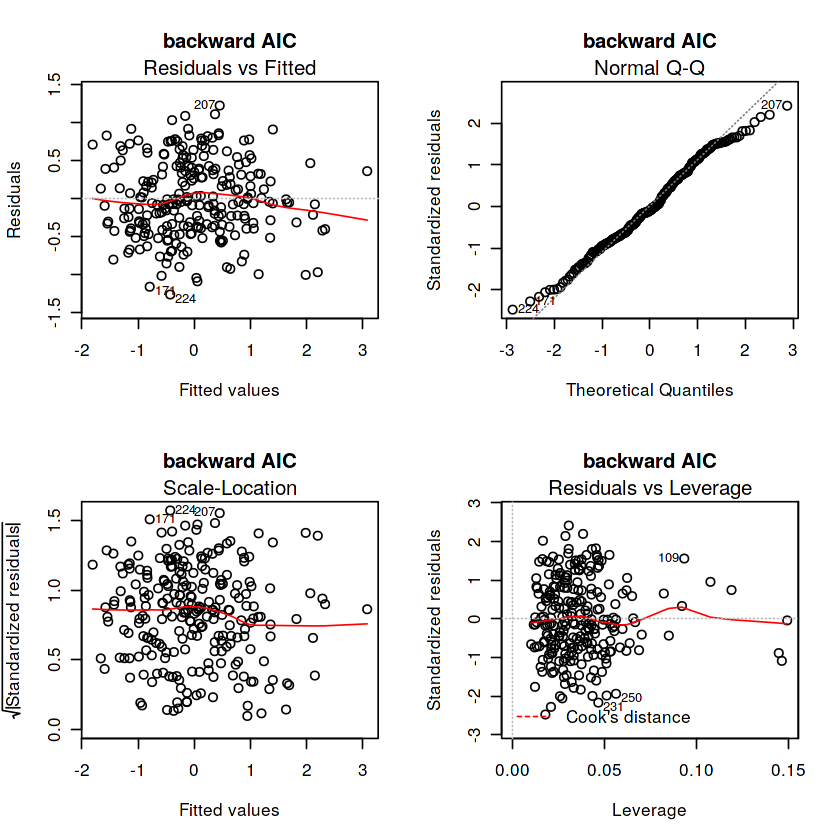

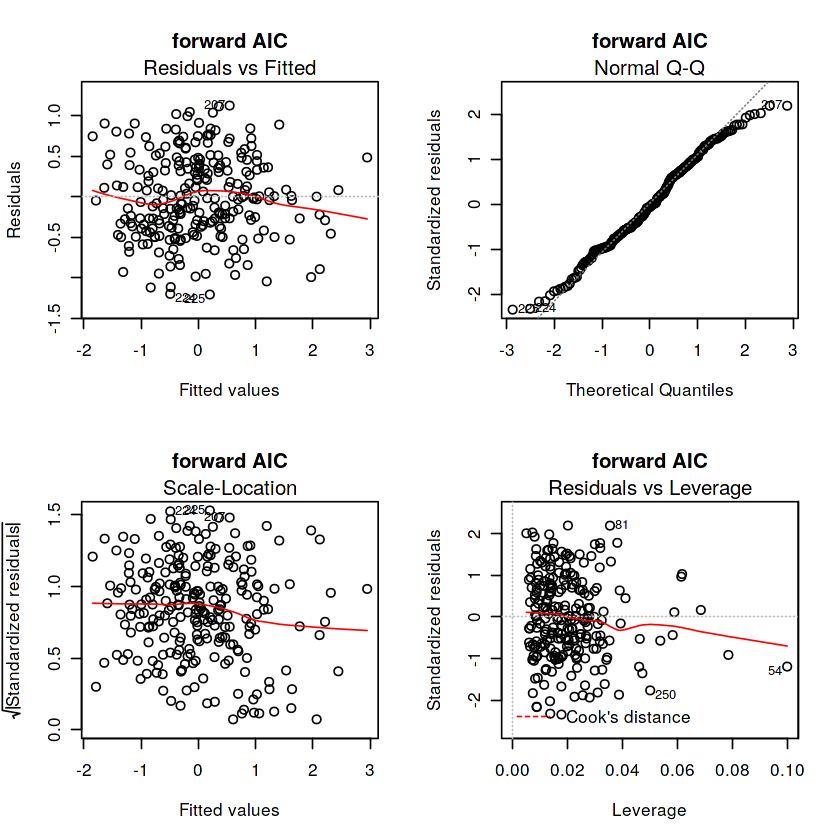

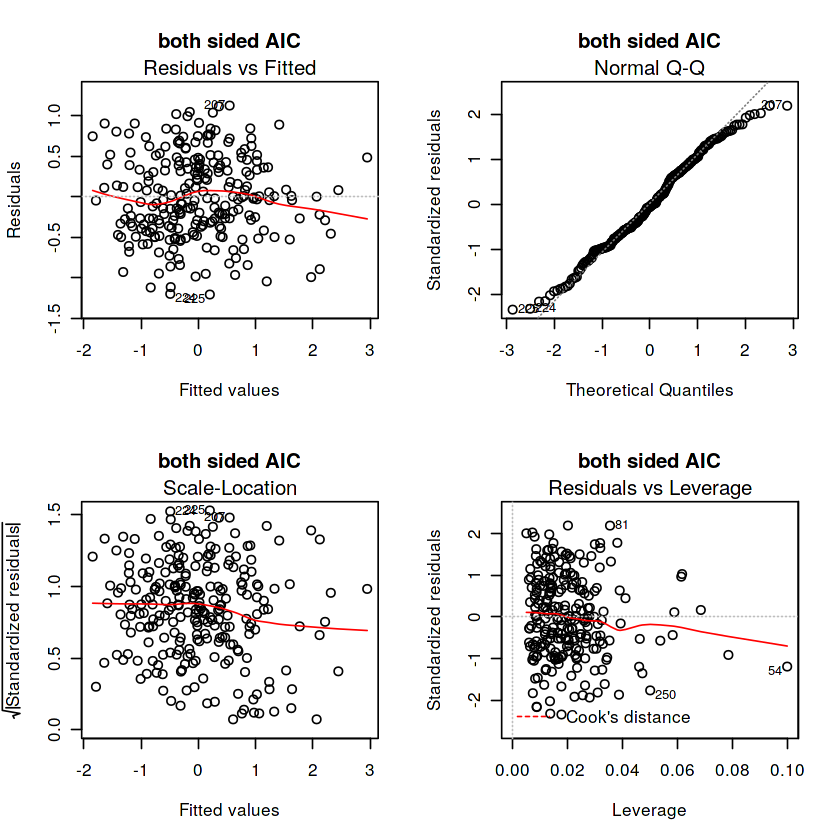

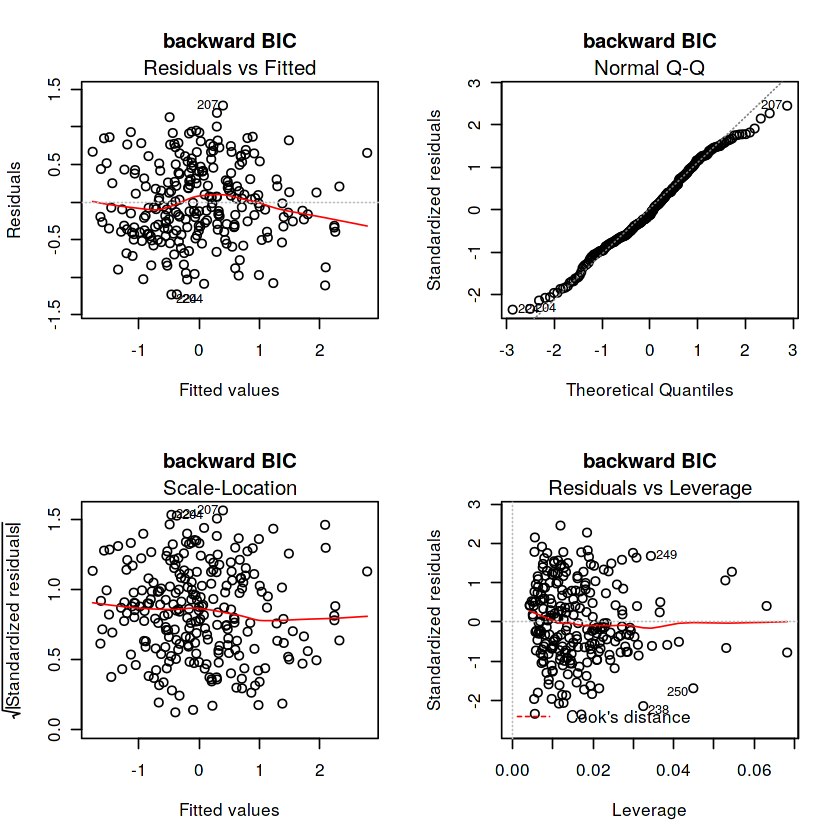

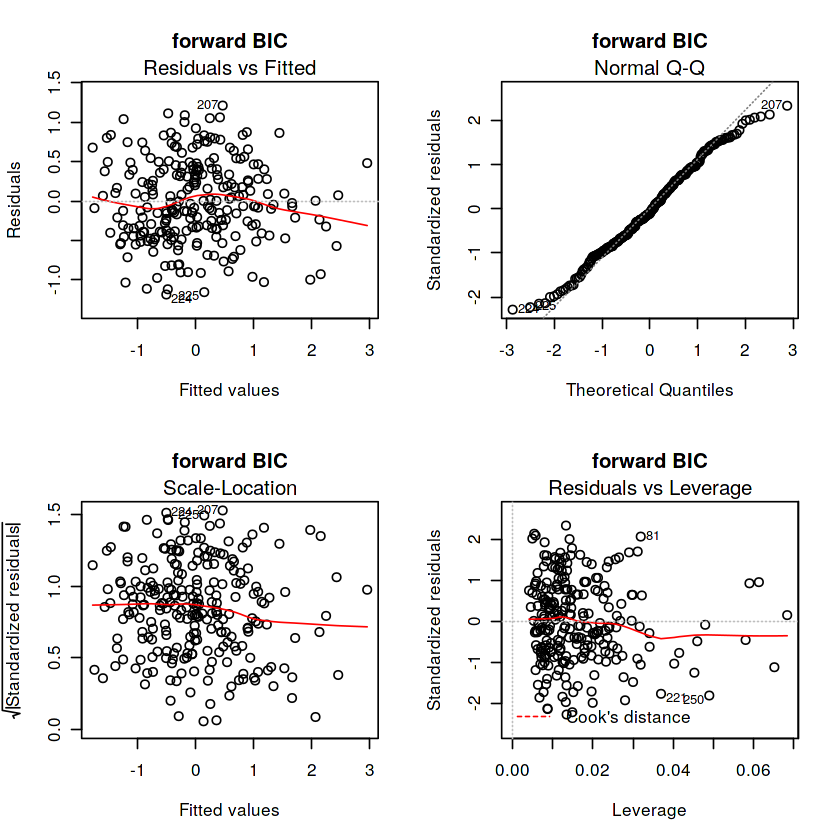

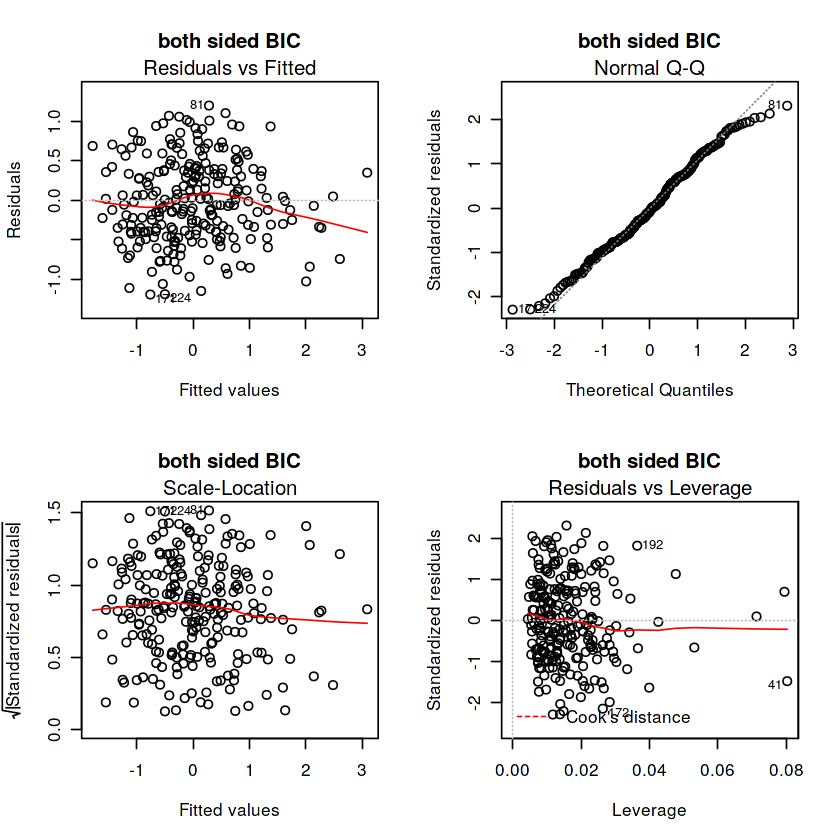

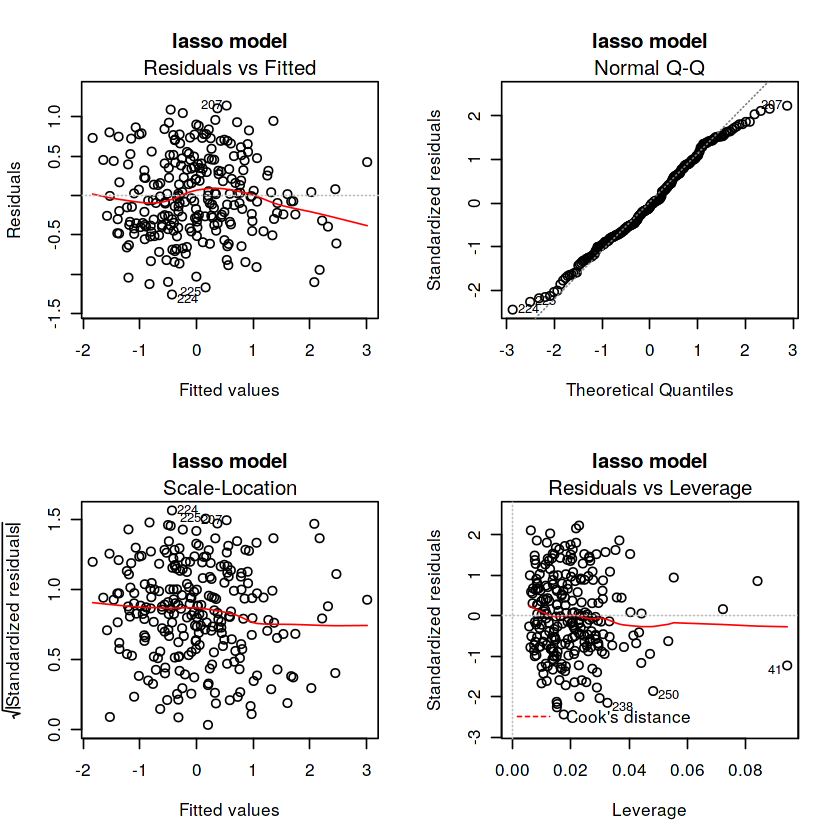

ERROR: Error in plot(adr_model, main = "adjusted Rsq model"): object 'adr_model' not found


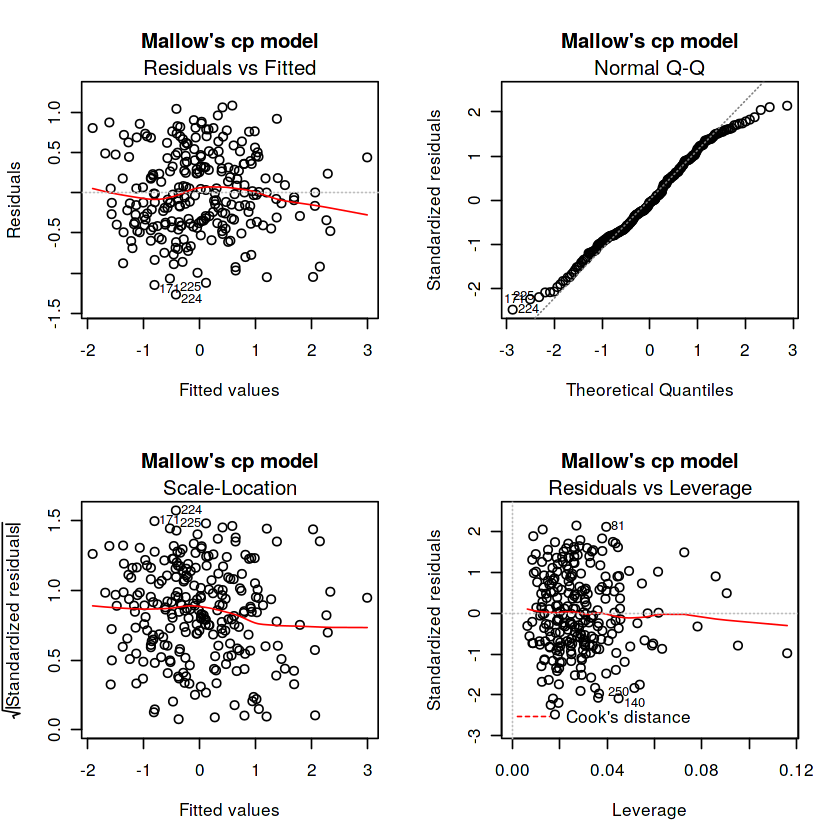

In [17]:
layout(matrix(1:4, byrow = TRUE, nrow = 2))
plot(model_AIC_b,main="backward AIC")
plot(model_AIC_f,main="forward AIC")
plot(model_AIC_t,main="both sided AIC")
plot(model_BIC_b,main="backward BIC")
plot(model_BIC_f,main="forward BIC")
plot(model_BIC_t,main="both sided BIC")
plot(model_l,main="lasso model")
plot(cp_lm,main="Mallow's cp model")
plot(adr_model,main="adjusted Rsq model")

#### Also do ANOVA table among them, model BIC forward is the best considering the F statistics and adjusted R square.

In [18]:
anova(model_AIC_b,model_AIC_f,model_AIC_t,model_BIC_f,model_BIC_b,model_BIC_t,cp_lm,adr_model,model_l)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
237,62.76420,NA,NA,NA,NA
241,65.14050,-4,-2.3762940,2.243244,0.06511255
241,65.14050,0,0.0000000,NA,NA
242,66.11273,-1,-0.9722287,3.671172,0.05656433
242,66.95461,0,-0.8418882,NA,NA
242,66.50566,0,0.4489551,NA,NA
239,63.80206,3,2.7035999,3.402965,0.01842968
241,65.20529,-2,-1.4032310,2.649327,0.07279230


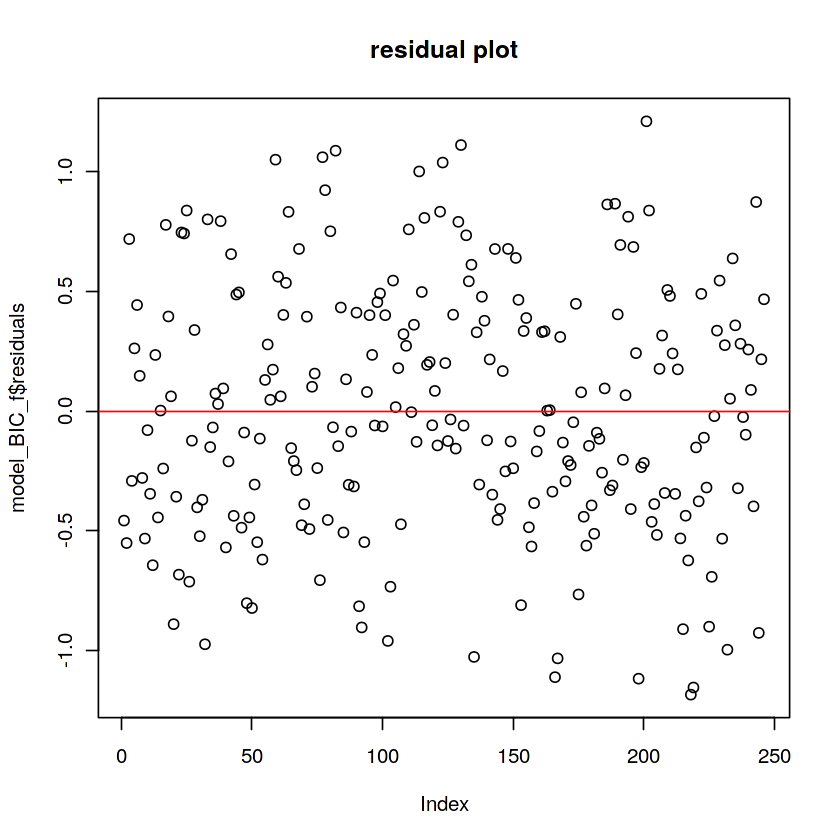

In [18]:
plot(model_BIC_f$residuals,main="residual plot")
abline(h=0,col="red")

### According to the model selection steps above, it seems that *abdomen, weight and wrist* are three most important predictors. By "rule of thumb" we can choose our predictors bamong them. Now check the possible multicolinearity betweeen abdomen, wrist and  weight.

In [19]:
cor(data_clean$WRIST,data_clean$ABDOMEN)
cor(data_clean$WEIGHT,data_clean$ABDOMEN)
cor(data_clean$WRIST,data_clean$WEIGHT)
vif(model_BIC_f)

[1] 0.5985732

[1] 0.8712262

[1] 0.7191773

ABDOMEN   WEIGHT    WRIST 
4.178125 5.553508 2.085366

#### It seems that these predictors are correlated but can not be considered as multicollinearity. We consider using only two variables and see the model's performence.

#### We consider using only two variables or even only one to see the model's performence-try to use only two x and check the model results

In [20]:
summary(lm(BODYFAT ~ ABDOMEN + WRIST, data = data_clean))
summary(lm(BODYFAT ~ ABDOMEN + WEIGHT, data = data_clean))
summary(lm(BODYFAT ~ ABDOMEN , data = data_clean))



Call:
lm(formula = BODYFAT ~ ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.22914 -0.38701 -0.02571  0.39153  1.36918 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.214e-16  3.422e-02   0.000        1    
ABDOMEN      9.695e-01  4.280e-02  22.650  < 2e-16 ***
WRIST       -2.470e-01  4.280e-02  -5.771  2.4e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5367 on 243 degrees of freedom
Multiple R-squared:  0.7143,	Adjusted R-squared:  0.7119 
F-statistic: 303.8 on 2 and 243 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.32159 -0.38979 -0.01124  0.38504  1.30644 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.536e-16  3.396e-02   0.000        1    
ABDOMEN      1.191e+00  6.933e-02  17.184  < 2e-16 ***
WEIGHT      -4.244e-01  6.933e-02  -6.121 3.71e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5327 on 243 degrees of freedom
Multiple R-squared:  0.7185,	Adjusted R-squared:  0.7162 
F-statistic: 310.2 on 2 and 243 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.32734 -0.43438  0.01972  0.37734  1.55636 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.551e-16  3.641e-02    0.00        1    
ABDOMEN     8.217e-01  3.649e-02   22.52   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5711 on 244 degrees of freedom
Multiple R-squared:  0.6751,	Adjusted R-squared:  0.6738 
F-statistic: 507.1 on 1 and 244 DF,  p-value: < 2.2e-16


In [21]:
#create cleaned data that are not scaled again
new_data_clean = data_new[c(-39, -42, -48, -96, -76, -182), ]

#### So our final model should be  BODYFAT ~ ABDOMEN leaving abdomen alone because it is the most important one and it can be easily measured.


Call:
lm(formula = BODYFAT ~ ABDOMEN, data = new_data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.097  -3.304   0.150   2.870  11.839 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -38.13152    2.55047  -14.95   <2e-16 ***
ABDOMEN       0.61760    0.02743   22.52   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.344 on 244 degrees of freedom
Multiple R-squared:  0.6751,	Adjusted R-squared:  0.6738 
F-statistic: 507.1 on 1 and 244 DF,  p-value: < 2.2e-16


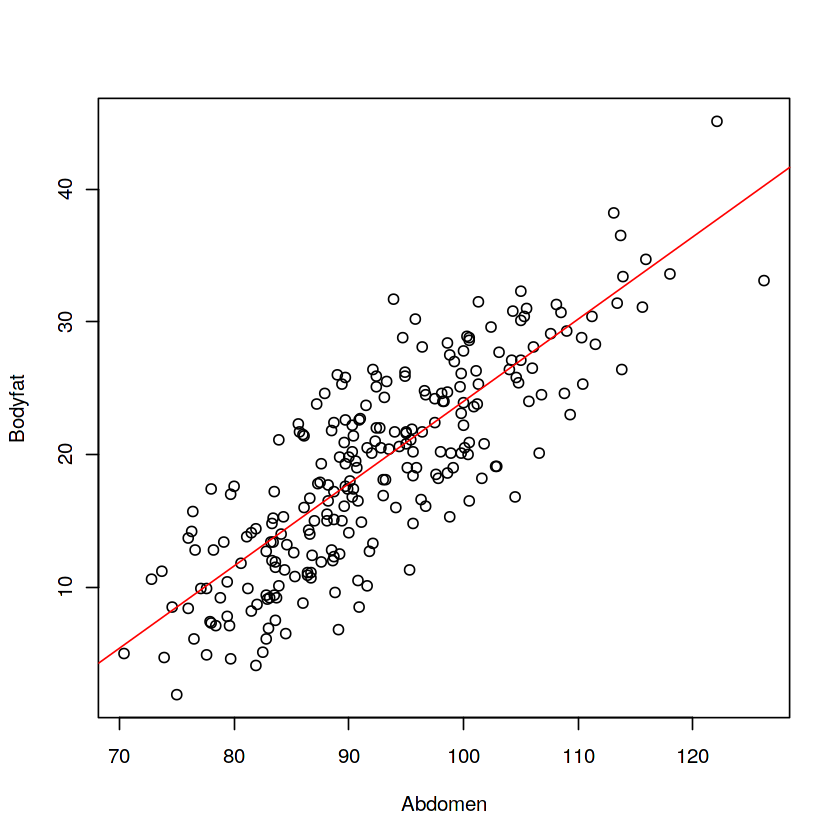

In [22]:
layout(1)
summary(lm(BODYFAT ~ ABDOMEN , data = new_data_clean))
plot(new_data_clean$ABDOMEN,new_data_clean$BODYFAT,xlab="Abdomen",ylab="Bodyfat")
abline(-38,0.62,col="red")

## Finally, we decide to take one-predictor model to continue making our prediction APP.

# Advantages of Our Model  

#### 1.Our final model is simple and straightforward. The variables included for prediction is easy to get.  
#### 2.The model is robust.  
#### 3.The model is accurate as the adjusted R-squared is greater than 0.6.  


# Contributions
